# Testing Performance of ViT on Synthetic DESI Supernovae -- V1

We will base performance metrics on the entire dataset, since it will include information from both the testing and training sample. Alternatively, we can save the split made during testing to ensure the test data utilized in the training graphs are utilized for these as well. 

In [1]:
import json
import os
import sys
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix

def is_interactive():
    import __main__ as main
    return not hasattr(main, "__file__")


if is_interactive():
    from tqdm.notebook import tqdm, trange
else:
    from tqdm import tqdm, trange

In [17]:
plt.rcParams.update({'font.size': 18})

## ViT Code

Again, this will be put into another file, but for now it is easier if it just lives in here for teh time being

In [3]:
# Helper methods for ViT
def patchify(spectra: torch.Tensor, n_patches: int) -> torch.Tensor:
    """
    spectra: 1D spectra: torch.Tensor of shape (N, 1, len_spectrum)
    n_patches: number of patches to break the spectra into (must be a factor of len_spectrum)

    return: patches of the spectra: torch.Tensor of shape (N, n_patches, len_spectrum // n_patches)
    """
    
    n, _, l_spectrum = spectra.shape
    
    # create patches
    patch_size = l_spectrum // n_patches
    patches = torch.zeros(n, n_patches, l_spectrum // n_patches)
    for idx, spectrum in enumerate(spectra):
        for i in range(n_patches):
            patch = spectrum[:, i * patch_size: (i + 1) * patch_size]
            patches[idx, i] = patch
    
    return patches


def positional_embedding(i, j, d):
    """
    i: tensor index
    j: embedding dimension

    return: positional embedding for i, j
    """
    
    if j % 2 == 0:
        return np.sin(i / (10000 ** (j / d)))
    return np.cos(i / (10000 ** ((j - 1) / d)))


def get_positional_embeddings(sequence_length: int, d) -> torch.Tensor:
    """
    sequence_length: length of sequence
    d: embedding dimension

    return: positional embeddings for sequence of length sequence_length
    """
    
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = positional_embedding(i, j, d)
    
    return result

class MSA(nn.Module):
    """
    Multi-Head Self-Attention
    """
    
    def __init__(self, d, n_heads=2):
        super(MSA, self).__init__()
        self.d = d
        self.n_heads = n_heads
        
        assert d % n_heads == 0, f"Cannot divide dimension {d} into {n_heads} heads"
        
        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, sequences):
        """
        Sequences have shapes (N, seq_length, token_dim)
        We must transform to shape (N, seq_length, n_heads, token_dim / n_heads)
        and concatenate back into (N, seq_length, token_dim)
        """
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]
                
                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)
                
                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


class ViTBlock(nn.Module):
    """
    Transformer Encoder Block
    """
    
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads
        
        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(nn.Linear(hidden_d, mlp_ratio * hidden_d), nn.GELU(),
                                 nn.Linear(mlp_ratio * hidden_d, hidden_d))
    
    def forward(self, x):
        """
        Encoder1 will normalize input, pass through MSA,
        add residual connection

        Encoder2 will normalize encoder1, pass through MLP
        """
        encoder1 = x + self.mhsa(self.norm1(x))
        encoder2 = encoder1 + self.mlp(self.norm2(encoder1))
        return encoder2


class ViT(nn.Module):
    def __init__(self, cl=(1, 1024), n_patches=64, n_blocks=2, hidden_d=8, n_heads=2, out_d=10, device = None):
        super(ViT, self).__init__()
        
        # If device is provided, use that. 
        # HOwever, if CUDA is availible, that is the default device
        if device is not None:
            self.device = device
        else:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"ViT IS NOW IN {self.device}")
        
        self.cl = cl  # (channels, length)
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        assert cl[1] % n_patches == 0, "Image length must be divisible by n_patches"
        self.patch_size = cl[1] // n_patches
        
        # Linear mapping of patches to hidden dimension
        self.input_d = int(cl[0] * self.patch_size)
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d).to(self.device)
        
        # Classification Token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d)).to(self.device)
        
        # Positional embeddings
        self.pos_embed = nn.Parameter(get_positional_embeddings(
            n_patches + 1, self.hidden_d).clone().detach())
        self.pos_embed.requires_grad = False
        
        # Transformer Encoder
        self.blocks = nn.ModuleList(
            [ViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]).to(self.device)
        
        # Classification mlp
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1)).to(self.device)
    
    def forward(self, images):
        # Creating patches
        n, _, _ = images.shape
        patches = patchify(images, self.n_patches).to(self.device)
        
        # Linear tokenization --> map vector corresponding to each patch to hidden dimension
        image_tokens = self.linear_mapper(patches)
        
        # Adding classification
        tokens = torch.stack([torch.vstack(
            (self.class_token, image_tokens[i])) for i in range(len(image_tokens))])
        
        # Adding positional embeddings
        pos_embed = self.pos_embed.repeat(n, 1, 1)
        out = tokens + pos_embed
        
        for block in self.blocks:
            out = block(out)
        
        # For classification, we take the first token
        out = out[:, 0]
        
        return self.mlp(out)
    
    def saveparams(self, model_name):
        dict = {'cl': self.cl, 'patches':self.n_patches, 'n_blocks':self.n_blocks, 'n_heads':self.n_heads, 'hidden_d':self.hidden_d}
        with open(f'{model_name}_parameters.json', 'w') as f:
            json.dump(dict, f)
            
def loadparams(model_name):
    with open(f'{model_name}_parameters.json', 'r') as f:
        params = json.load(f)
    return params
 

In [7]:
print("Testing ViT Training")
print("-"* 20)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE IN USE {device}")
model_name = 'vit_model_lens-3600'

Testing ViT Training
--------------------
DEVICE IN USE cpu


In [8]:
%%time 



# model = ViT(cl=(1, spectra_length), n_patches=patch_num, n_blocks=4, hidden_d = patch_num // 4, n_heads = 5, out_d = 6).to(device)


CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.58 µs


In [9]:
# Diagnostic of Training
with open(f"{model_name}_history.json", "r") as f:
    model_history = json.load(f)
print("Model loaded")
numepoch = len(model_history['training_loss'])
# history_figure1, hist_ax = plot_history(model_history, figure = None)

Model loaded


In [18]:
def plot_history(history: dict, figure=None):
    """
    Plot training history

    Parameters
    ----------
    history: dict
        Dictionary with training history
    figure: tuple
        Tuple of (fig, ax) to plot on

    Returns
    -------
    fig, ax
        Figure and axis
    """
    # plot on one axis, with two y axes (one for loss, one for accuracy)
    
    # figure is either None, or a tuple of (fig, ax)
    if figure is None:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
        assert isinstance(ax1, plt.Axes), "Figure must be a tuple of (fig, ax)"
        ax2 = ax1.twinx()
    else:
        fig, ax = tuple(figure)
        if isinstance(ax, np.ndarray):
            ax1 = ax[0]
            ax2 = ax[1]
        else:
            assert isinstance(
                ax, plt.Axes), "Figure must be a tuple of (fig, ax)"
            ax1 = ax
            ax2 = ax1.twinx()
    
    assert isinstance(ax1, plt.Axes), "Figure must be a tuple of (fig, ax)"
    assert isinstance(ax2, plt.Axes), "Figure must be a tuple of (fig, ax)"
    
    # List of colors to be used
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
              "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(history["training_loss"], label="Training loss", color=colors[0])
    ax1.plot(history["test_loss"], label="Test loss", color=colors[1])
    ax1.legend()
    
    ax2.set_ylabel("Accuracy")
    # Use the 3rd color in the color cycle
    ax2.plot(history["test_acc"], label="Test accuracy", color=colors[2])
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax = (ax1, ax2)
    fig.tight_layout()
    
    return fig, ax

Best Test Accuracy:	50
Best Test Loss:		55


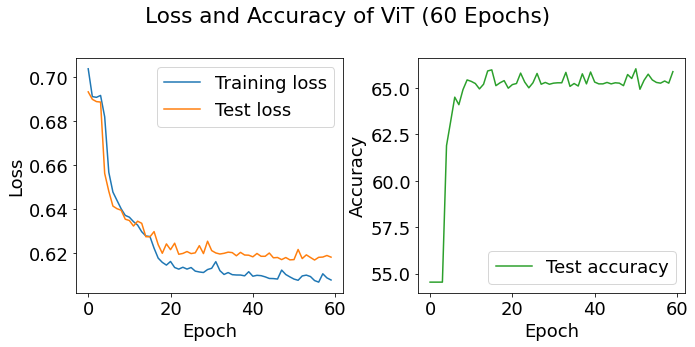

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
history_figure2, hist_ax = plot_history(model_history, figure = (fig, ax))
history_figure2.suptitle(f"Loss and Accuracy of ViT ({numepoch} Epochs)")
history_figure2.tight_layout()
history_figure2.savefig(f"graphs/{model_name}training_after.png", dpi=300, facecolor='white', transparent=False, edgecolor='none')
print(f'Best Test Accuracy:\t{np.argmax(model_history["test_acc"])}')
print(f'Best Test Loss:\t\t{np.argmin(model_history["test_loss"])}')

In [20]:
x_val = torch.Tensor(np.load('split/V1_xval.npy'))

e_num = 59
params = loadparams(model_name)
model = ViT(
    cl=params['cl'], 
    n_patches=params['patches'], 
    n_blocks=params['n_blocks'], 
    hidden_d = params['hidden_d'],
    n_heads = params['n_heads'],
    out_d = 2).to(device)
print(params)
# state = model.load_state_dict(torch.load(f'model/{model_name}_epoch{e_num}.pt', map_location=device))
state = model.load_state_dict(torch.load(f'model/{model_name}_epoch{e_num}.pt', map_location=device))
print(f'{state}, {model_name} at Epoch {e_num} loaded')

ViT IS NOW IN cpu
{'cl': [1, 3600], 'patches': 100, 'n_blocks': 4, 'n_heads': 12, 'hidden_d': 72}
<All keys matched successfully>, vit_model_lens-3600 at Epoch 59 loaded


In [ ]:
def predict_data(model, input, device):
    model.eval()
    with torch.no_grad():
        input.to(device)
        output = model(input)
    
    return output

y_predicted = predict_data(model, x_val, device)
print(f"Done, {len(x_val)} predictions made!")

In [ ]:
np.save(f'results/{model_name}_pval_e{e_num}.npy', y_predicted.cpu())
print(f"Results for Epoch {e_num} saved")

## Loading of predictions and diagnostic graphs

In [21]:
# x = np.load('results/test2_input.npy')

def to_categorical(y, num_classes=None, dtype="float32"):
    ## THIS IS TAKEN DIRECTLY FROM TENSORFLOW KERAS.TO_CATEGORICAL!!!!

    y = np.array(y, dtype="int")
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical


y_val = to_categorical(np.load('split/V1_yval.npy'),2)
y_pred = np.load(f'results/{model_name}_pval_e{e_num}.npy')

In [22]:
# print(f"Shape of input data: {x.shape}")
print(f"Shape of labels: {y_val.shape}")
print(f"Shape of predictions: {y_pred.shape}")
labels = ['lenses','background']

ntypes = len(labels)

Shape of labels: (5171, 2)
Shape of predictions: (5171, 2)


In [27]:
def plot_roc_curve(y_val, y_pred, labels, mask = None):
    assert len(y_val) == len(y_pred)
    ntypes = len(labels)
    if mask is None:
        mask = np.ones(len(y_val), dtype=bool)

    fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

    all_fpr = None
    all_tpr = None

    fpr = dict()
    tpr = dict()
    pre = dict()
    rec = dict()
    for i in range(ntypes):
        fpr[i], tpr[i], _ = roc_curve(y_val[mask][:,i], y_pred[mask][:,i])        
        roc_auc = auc(fpr[i], tpr[i])
        
        ax = axes[0]
        ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
        ax.grid(ls=':')
        
        pre[i], rec[i], _ = precision_recall_curve(y_val[mask][:,i], y_pred[mask][:,i])
        
        ax = axes[1]
        ax.plot(rec[i], pre[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(ntypes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr / ntypes
    fpr['macro'] = np.insert(fpr['macro'], 0, 0)
    tpr['macro'] = np.insert(tpr['macro'], 0, 0)
    roc_auc_macro = auc(fpr['macro'], tpr['macro'])
            
    ax = axes[0]
    ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
            label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
    ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
        ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
        title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
        aspect='equal')
    ax.legend(fontsize=10, loc='lower right')

    ax = axes[1]
    pre['micro'], rec['micro'], _ = precision_recall_curve(y_val[mask].ravel(), y_pred[mask].ravel())
    ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

    f_scores = np.linspace(0.1, 0.9, num=5)
    for f_score in f_scores:
        x_ = np.linspace(0.01, 1)
        y_ = f_score * x_ / (2 * x_ - f_score)
        l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
        ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                    fontsize=12, alpha=0.8)
    ax.grid(ls=':')
    ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
        ylabel='precision = TP / (TP + FP)',
        title='Average precision = {:.3f}'.format(average_precision_score(y_val[mask], y_pred[mask])),
        aspect='equal')

    fig.tight_layout()
    
    return fig, axes

def create_confusion_matrix(y_val, y_pred, labels, mask=None):
    assert len(y_val) == len(y_pred)
    if mask is None :
        mask = np.ones(len(y_val), dtype=bool)
        
    cm = confusion_matrix(y_val[mask].argmax(axis=1), y_pred[mask].argmax(axis=1))
    cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(1,1, figsize=(11,8.5))

    im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
    cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label('correct label fraction')

    ax.set(aspect='equal',
        xlabel='predicted label',
        xticks=np.arange(cm.shape[1]),
        xticklabels=labels,
        ylabel='true label',
        yticks=np.arange(cm.shape[1]),
        yticklabels=labels)

    # thresh = 0.5*cm.max()
    thresh = np.average(cm)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                    ha='center', va='center',
                    color='black' if cm[i,j] < thresh else 'white')

    fig.tight_layout()
    
    return fig, ax

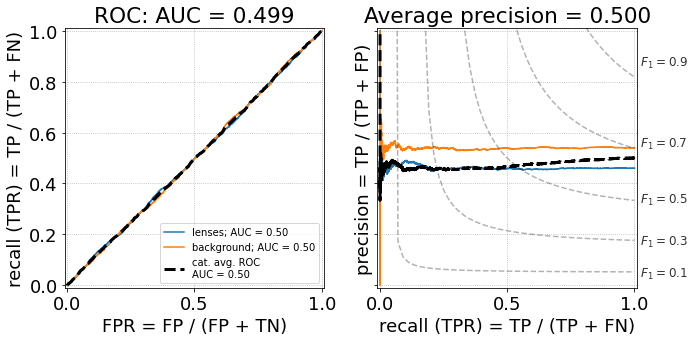

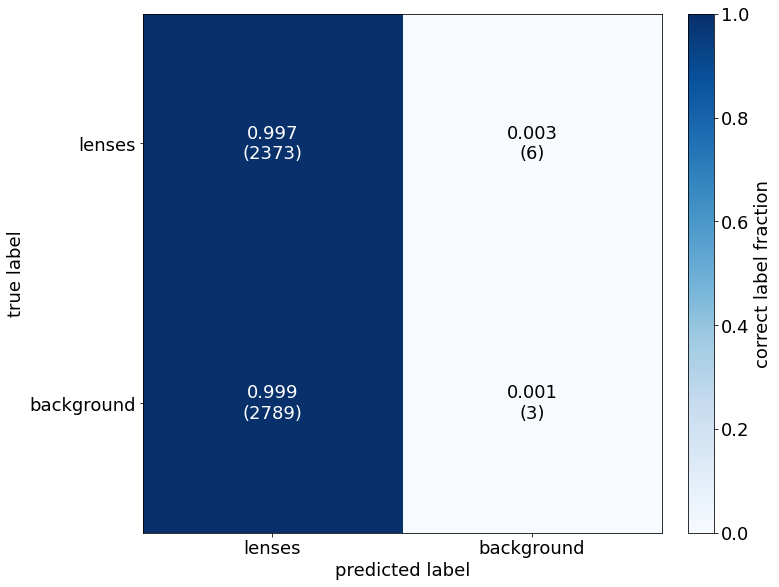

In [28]:
fig_roc_full, ax_roc_full = plot_roc_curve(y_val, y_pred, labels)
fig_cm_full, ax_cm_full = create_confusion_matrix(y_val, y_pred, labels)
fig_roc_full.savefig(f"graphs/{model_name}rocfulle_e{e_num}.png", dpi=300, facecolor='white', transparent=False, edgecolor='none', bbox_inches='tight')
fig_cm_full.savefig(f"graphs/{model_name}cmfull_e{e_num}.png", dpi=300, facecolor='white', transparent=False, edgecolor='none', bbox_inches='tight')

In [ ]:
i = np.argmax(y_pred, axis=1)
y_max = np.max(y_pred, axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,5), tight_layout=True)
ax.hist(y_max, bins=np.linspace(0,1,51))
ax.set(xlabel='$\\max{(y_\\mathrm{pred})}$',
       ylabel='count')
ax.grid(ls=':')
fig.savefig(f'graphs/{model_name}max_ypred_{e_num}.png', dpi=120, facecolor='white', transparent=False, edgecolor='none')

In [ ]:
print(np.sum(y_max > 0.6) / len(y_max))
select = y_max > 0.6
print(f"Selected {np.sum(select)} of {len(y_max)} with {len(np.unique(y_pred[select].argmax(axis=1), return_counts=False))} unique classes")
print(len(y_val))

In [ ]:
fig, axes = plot_roc_curve(y_val, y_pred, labels, mask = y_max > 0.9)
#fig.savefig('6label_roc_pr_y99_5.png', dpi=120)
fig1, ax2 = create_confusion_matrix(y_val, y_pred, labels, mask = y_max > 0.9)
fig.savefig(f"graphs/{model_name}roc90_e{e_num}.png", dpi=300, facecolor='white', transparent=False, edgecolor='none', bbox_inches='tight')
fig1.savefig(f"graphs/{model_name}cm90_e{e_num}.png", dpi=300, facecolor='white', transparent=False, edgecolor='none', bbox_inches='tight')